The goal of this code is to predict how long a flight will be delayed given that we already know that the flight will be delayed.

In [167]:
import json
import numpy as np
import pandas as pd
# Machine learning and data preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# Handling class imbalance
from imblearn.over_sampling import RandomOverSampler
# Advanced boosting framework
from xgboost import XGBClassifier
# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns

In [169]:
#preprocessing data
df = pd.read_csv('data/preprocessed_df.csv')

#remove any rows with DepDelay <= 0
df = df[df['DepDelay'] > 0]

#remove other columns
#DaysSince, MinSince - Used to make other variables and dont provide any information
#FlightDate - Information is already in other columns(Year, Month, DayofMonth, DayOfWeek)
#is_holiday, is_day_before_holiday - is_holiday_week captures more information
#Tail_Number - It's a unique identifier for each plane
#Flight_Number_Reporting_Airline - It's a unique identifier for each flight

df = df.drop(columns=['Quarter','FlightDate', #information is already in other columns
                      'OriginAirportSeqID', 'OriginCityName', 'OriginState', #same as Origin
                      'DestAirportSeqID', 'DestCityName', 'DestState', #same as Dest
                      'DaysSince', 'MinSince', #used to make other variables
                      'is_holiday', 'is_day_before_holiday', #is_holiday_week captures more information
                      'Tail_Number', 'Flight_Number_Reporting_Airline']) #unique identifier for each plane and flight

print(df.columns)
print(df.shape)

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Reporting_Airline',
       'Origin', 'Dest', 'CRSDepTime', 'DepDelay', 'CRSArrTime', 'Cancelled',
       'Diverted', 'CRSElapsedTime', 'Distance', 'is_holiday_week',
       'DepartureDensity', 'ArrivalDensity', 'TotalDensity', 'Visibility',
       'WindSpeed', 'SevereWeather', 'BadWeather'],
      dtype='object')
(686346, 22)


In [69]:
# turn all non-numerical data into numerical data, using .factorize()
object_cols = df.select_dtypes(include='object').columns
df_nums = df.copy()
for col in object_cols:
    df_nums[col], _ = pd.factorize(df[col])

#This shows the mapping of the categorical data to numerical data
print("Conversions of categorical data to numerical data:")
for col in object_cols:
    print(f"{col}:")
    print("Original:", df[col].unique())
    print("Converted:", df_nums[col].unique())

Conversions of categorical data to numerical data:
Reporting_Airline:
Original: ['UA' 'DL' 'WN' 'AA' 'OO']
Converted: [0 1 2 3 4]
Origin:
Original: ['ATL' 'CLT' 'DEN' 'DFW' 'IAH' 'LAX' 'ORD' 'PHX' 'SFO']
Converted: [0 1 2 3 4 5 6 7 8]
OriginCityName:
Original: ['Atlanta, GA' 'Charlotte, NC' 'Denver, CO' 'Dallas/Fort Worth, TX'
 'Houston, TX' 'Los Angeles, CA' 'Chicago, IL' 'Phoenix, AZ'
 'San Francisco, CA']
Converted: [0 1 2 3 4 5 6 7 8]
OriginState:
Original: ['GA' 'NC' 'CO' 'TX' 'CA' 'IL' 'AZ']
Converted: [0 1 2 3 4 5 6]
Dest:
Original: ['ORD' 'LAX' 'DEN' 'PHX' 'DFW' 'SFO' 'CLT' 'IAH' 'ATL']
Converted: [0 1 2 3 4 5 6 7 8]
DestCityName:
Original: ['Chicago, IL' 'Los Angeles, CA' 'Denver, CO' 'Phoenix, AZ'
 'Dallas/Fort Worth, TX' 'San Francisco, CA' 'Charlotte, NC' 'Houston, TX'
 'Atlanta, GA']
Converted: [0 1 2 3 4 5 6 7 8]
DestState:
Original: ['IL' 'CA' 'CO' 'AZ' 'TX' 'NC' 'GA']
Converted: [0 1 2 3 4 5 6]


In [70]:
#convert DepDelay into bins
#1 - 15 - 30 min
#2 - 30-60
#3 - 1hr-2hr
#4 - 2-5hr
#5 - over 5hr

bins = [15, 30, 60, 120, 300, df_nums['DepDelay'].max()]
labels = [0, 1, 2, 3, 4]
df_nums['DepDelay'] = pd.cut(df_nums['DepDelay'], bins=bins, labels=labels)
#drop rows with NaN
df_nums = df_nums.dropna()

print(df_nums['DepDelay'].head(10))
print(df_nums['DepDelay'].value_counts())

3     0
16    0
23    0
38    1
52    2
55    1
56    2
57    0
65    0
66    0
Name: DepDelay, dtype: category
Categories (5, int64): [0 < 1 < 2 < 3 < 4]
DepDelay
0    119619
1    100529
2     68756
3     32937
4      3889
Name: count, dtype: int64


In [42]:
#split the data into training and testing
X = df_nums.drop(columns=['DepDelay'])
y = df_nums['DepDelay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

0.36620820925306236


<Axes: >

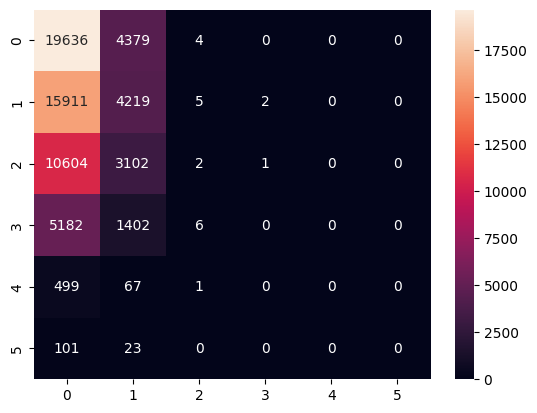

In [43]:
#modeling using the simple bayes approach

gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)


print(accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

0.30497651429097716


<Axes: >

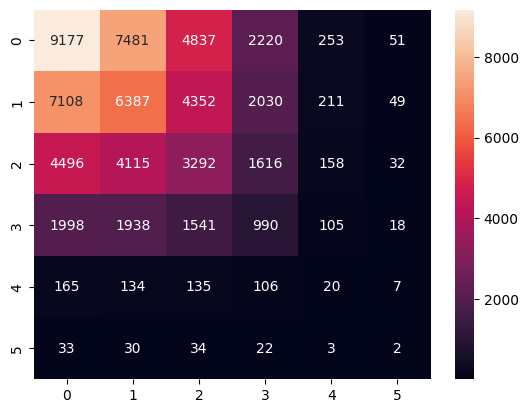

In [44]:
#decision tree approach
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print(accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

0.3790409234642188


<Axes: >

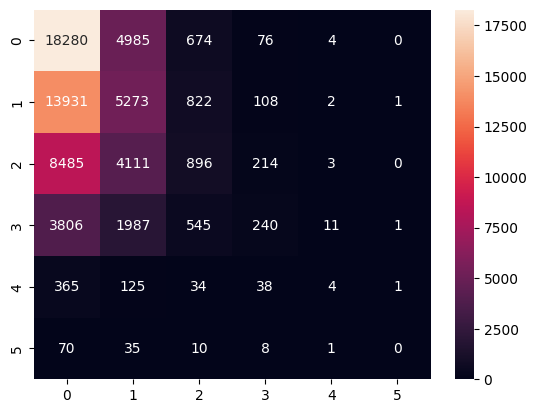

In [45]:
#xgboost approach
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

print(accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

0.3421545451754521


<Axes: >

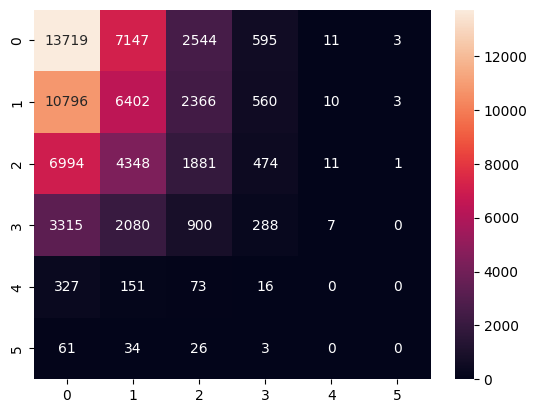

In [46]:
#knn approach

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

0.3553403125287815


<Axes: >

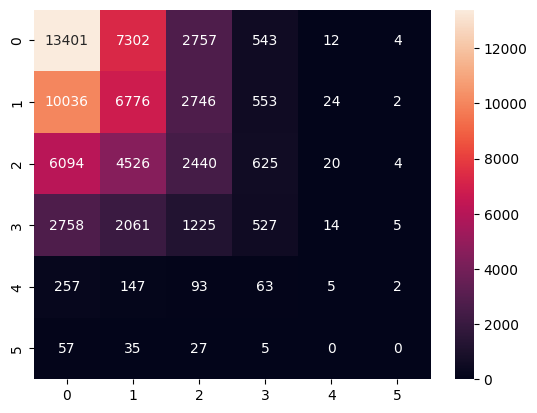

In [47]:
#random forest approach

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')


In [48]:
#naive bayes approach
gnb = GaussianNB()

param_grid = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

grid_search = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

y_pred = grid_search.best_estimator_.predict(X_test)

print(accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END ..................................var_smoothing=1.0; total time=   0.3s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.4s
[CV] END ..................................var_smoothing=1.0; total time=   0.4s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.4s
[CV] END ..................................var_smoothing=1.0; total time=   0.4s
[CV] END ..................................var_smoothing=1.0; total time=   0.5s
[CV] END ..................................var_smoothing=1.0; total time=   0.5s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.5s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.1s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.2s
[CV] END ....................var_smoothing=0.657933224657568; total time=   0.2s
[CV] END ....................var_smoothing=0.6

In [49]:
#most important features of naive bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)

feature_importance = gnb.theta_
feature_importance = feature_importance[0]
feature_importance = pd.Series(feature_importance, index=X_train.columns)
feature_importance = feature_importance.sort_values(ascending=False)

#print sorted feature importance percentages
total = feature_importance.sum()
feature_importance = round((feature_importance/total)*100, 2)
print(feature_importance)


DestAirportSeqID       50.03
OriginAirportSeqID     49.72
Year                    0.08
CRSArrTime              0.06
CRSDepTime              0.06
Distance                0.04
CRSElapsedTime          0.01
OriginFlightDensity     0.00
DayofMonth              0.00
WindSpeed               0.00
Visibility              0.00
Month                   0.00
Origin                  0.00
OriginCityName          0.00
DayOfWeek               0.00
Dest                    0.00
DestCityName            0.00
OriginState             0.00
Quarter                 0.00
DestState               0.00
Reporting_Airline       0.00
is_holiday_week         0.00
BadWeather              0.00
SevereWeather           0.00
Diverted                0.00
Cancelled               0.00
dtype: float64


In [30]:
#Taking a deeper look at the random forest model

#hyperparameter tuning
param_grid = {
    'n_estimators': [200, 300, 1000],
    'max_depth': [5, 10, 15, 20]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2) #no cv cv=0
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV] END ......................max_depth=5, n_estimators=200; total time=  31.9s
[CV] END ......................max_depth=5, n_estimators=200; total time=  30.6s
[CV] END ......................max_depth=5, n_estimators=300; total time=  50.0s
[CV] END ......................max_depth=5, n_estimators=300; total time=  50.2s
[CV] END .....................max_depth=10, n_estimators=200; total time=  55.2s
[CV] END .....................max_depth=10, n_estimators=200; total time=  55.0s
[CV] END .....................max_depth=5, n_estimators=1000; total time= 2.5min
[CV] END .....................max_depth=10, n_estimators=300; total time= 1.3min
[CV] END .....................max_depth=5, n_estimators=1000; total time= 2.5min
[CV] END .....................max_depth=10, n_estimators=300; total time= 1.3min
[CV] END .....................max_depth=15, n_estimators=200; total time= 1.2min
[CV] END .....................max_depth=15, n_es

/opt/homebrew/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END .....................max_depth=20, n_estimators=200; total time= 1.7min
[CV] END .....................max_depth=15, n_estimators=300; total time= 2.0min
[CV] END .....................max_depth=15, n_estimators=300; total time= 2.0min
[CV] END ....................max_depth=10, n_estimators=1000; total time= 4.3min
[CV] END ....................max_depth=10, n_estimators=1000; total time= 4.4min
[CV] END .....................max_depth=20, n_estimators=300; total time= 2.1min
[CV] END .....................max_depth=20, n_estimators=300; total time= 2.1min
[CV] END ....................max_depth=15, n_estimators=1000; total time= 5.6min
[CV] END ....................max_depth=15, n_estimators=1000; total time= 5.6min
[CV] END ....................max_depth=20, n_estimators=1000; total time= 5.7min
[CV] END ....................max_depth=20, n_estimators=1000; total time= 5.7min
{'max_depth': 10, 'n_estimators': 200}
0.32027837205385395
RandomForestClassifier(max_depth=10, n_estimators=

In [29]:
#tuning xgboost
param_grid = {
    'n_estimators': [200, 500, 1000],
    'max_depth': [5,10,15],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.5, 0.7, 0.9]
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=2, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

Fitting 2 folds for each of 81 candidates, totalling 162 fits
[CV] END learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.9; total time=  45.3s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.9; total time=  46.4s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.7; total time=  46.9s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.5; total time=  47.0s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.7; total time=  47.5s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.5; total time=  48.8s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.5; total time= 2.1min
[CV] END learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.5; total time= 2.2min
[CV] END learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.9; total time= 2.1min
[CV] END learning_rate=0.01, max_depth=5, n_estimators=500, subsample=0.9; total time= 2.1mi

/opt/homebrew/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.5; total time= 1.9min
[CV] END learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.5; total time= 4.9min
[CV] END learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.5; total time= 5.0min
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.7; total time= 1.8min
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.7; total time= 1.8min
[CV] END learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.7; total time= 5.1min
[CV] END learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.7; total time= 5.2min
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.9; total time= 1.8min
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.9; total time= 1.7min
[CV] END learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.9; total time= 5.1min
[CV] END learning_rate=0.01, max_depth=5, n_estima

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.9}
0.19649633937882321
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)
0.27565422163999875
Feature ranking:
1. feature CRSDepTime (0.1757405698299408)
2. feature Reporting_Airline (0.08787256479263306)
3. feat

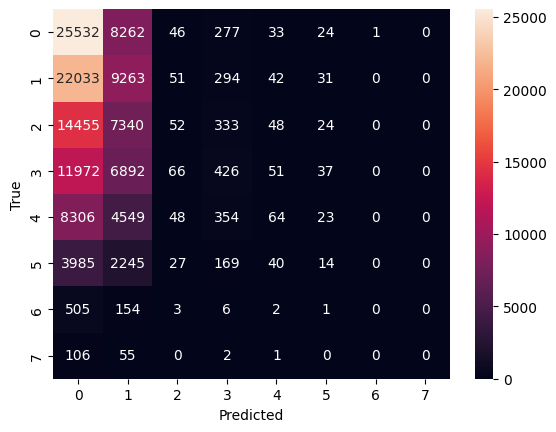

In [35]:
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

#print the accuracy of the best model
y_pred = grid_search.best_estimator_.predict(X_test)
print(accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
#with labels
plt.xlabel('Predicted')
plt.ylabel('True')


#print the most important features
importances = grid_search.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f+1}. feature {X_train.columns[indices[f]]} ({importances[indices[f]]})")

In [ ]:
#tuning knn

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)



In [ ]:
#tuning decision tree

param_grid = {
    'max_depth': [4,6,8,10,12,14,16,20,30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_leaf_nodes': [None, 10, 20, 30, 40, 50],
    'class_weight': ['balanced', None]
}


grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)


In [15]:
#use a random sample of 10,000 rows 
df_sample = df_nums.sample(n=100000, random_state=3)

#drop OriginAirportSeqID, OriginCityName, OriginState, DestAirportSeqID, DestCityName, DestState, Cancelled, Diverted

df_sample = df_sample.drop(columns=['OriginAirportSeqID', 'OriginCityName', 'OriginState', 'DestAirportSeqID', 'DestCityName', 'DestState', 'Cancelled', 'Diverted'])

X_sample = df_sample.drop(columns=['DepDelay'])
y_sample = df_sample['DepDelay']

#show all columns
pd.set_option('display.max_columns', None)
X_sample.head()

#print(df_sample.shape) #(10000, 17)

,Year,Quarter,Month,DayofMonth,DayOfWeek,Reporting_Airline,Origin,Dest,CRSDepTime,CRSArrTime,CRSElapsedTime,Distance,is_holiday_week,OriginFlightDensity,Visibility,WindSpeed
1444543,2014,1,3,21,5,0,8,2,1516,1850,154.0,967.0,0,21.0,10.00,16.0
1341691,2016,2,4,29,5,1,7,8,1546,2224,218.0,1587.0,0,20.0,10.00,13.0
1032126,2018,2,6,13,3,3,5,8,951,1730,279.0,1947.0,0,30.0,4.00,9.0
367435,2016,1,3,28,1,0,2,5,1420,1602,162.0,967.0,0,21.0,10.00,22.0
471018,2018,4,10,7,7,4,2,4,1740,2035,115.0,641.0,1,17.0,0.25,14.0


In [16]:
#split the data into training and testing

X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample, y_sample, test_size=0.2, random_state=32)

#modeling using xgboost

xgb = XGBClassifier(n_estimators=2000, max_depth=4, learning_rate=0.1, subsample=0.7)
xgb.fit(X_train_sample, y_train_sample)

y_pred_sample = xgb.predict(X_test_sample)

print(accuracy_score(y_test_sample, y_pred_sample))

0.27535


0.2826
DepDelay
0    188705
1    171911
2    119619
3    100529
4     68756
5     32937
6      3195
7       694
Name: count, dtype: int64


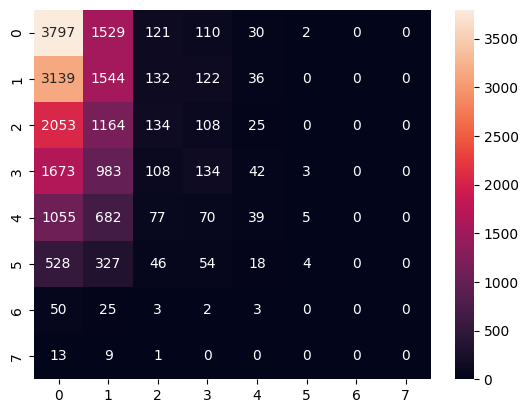

In [17]:
#preform pca and run xgboost again

scaler = StandardScaler()
X_train_sample_scaled = scaler.fit_transform(X_train_sample)
X_test_sample_scaled = scaler.transform(X_test_sample)

pca = PCA(n_components=15)
X_train_sample_pca = pca.fit_transform(X_train_scaled)
X_test_sample_pca = pca.transform(X_test_sample_scaled)

xgb = XGBClassifier(n_estimators=1000, max_depth=7, learning_rate=0.01, subsample=0.7)
xgb.fit(X_train_pca, y_train_sample)

y_pred_sample = xgb.predict(X_test_sample_pca)

print(accuracy_score(y_test_sample, y_pred_sample))

cm = confusion_matrix(y_test_sample, y_pred_sample)
sns.heatmap(cm, annot=True, fmt='d')

#print the number of unique values in depdelay
print(df_nums['DepDelay'].value_counts())

In [18]:
#preform hyperparameter tuning on the pca data

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5,10],
    'learning_rate': [0.01, 0.1],
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=2, n_jobs=1, verbose=2)
grid_search.fit(X_train_sample_pca, y_train_sample)

print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
print(grid_search.best_estimator_.feature_importances_)
print(grid_search.best_estimator_.n_features_in_)

Fitting 2 folds for each of 8 candidates, totalling 16 fits
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   1.2s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=   1.3s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time=   2.8s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=200; total time=   2.7s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=100; total time=   5.4s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=100; total time=   4.7s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=200; total time=   9.4s
[CV] END .learning_rate=0.01, max_depth=10, n_estimators=200; total time=   9.0s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   1.2s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=   1.3s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=200; total time=   2.8s
[CV] END ...learning_rate=0.1, max_depth=5, n_est

In [19]:
#use svm on the pca data

#kernel = 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'
#degree = 3, 4, 5, 6
#gamma = 'scale', 'auto'
#C = 1.0, 10.0, 100.0, 1000.0

param_grid = {
    'kernel': ['linear', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'C': [1.0, 10.0]
}

""" param_grid = { #0.257
    'kernel': ['poly'],
    'degree': [3, 4, 5, 6],
    'gamma': ['scale', 'auto'],
    'C': [1.0, 10.0]
} """
svc = SVC()
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=2, n_jobs=1, verbose=2)
grid_search.fit(X_train_sample_pca, y_train_sample)

print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.best_estimator_)
#print(grid_search.best_estimator_.n_features_in_)
#print(grid_search.best_estimator_.n_support_)

y_pred_sample = grid_search.best_estimator_.predict(X_test_sample_pca)

print(accuracy_score(y_test_sample, y_pred_sample))


Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV] END ..................C=1.0, gamma=scale, kernel=linear; total time= 1.3min
[CV] END ..................C=1.0, gamma=scale, kernel=linear; total time= 1.7min
[CV] END .....................C=1.0, gamma=scale, kernel=rbf; total time= 2.2min
[CV] END .....................C=1.0, gamma=scale, kernel=rbf; total time= 2.2min
[CV] END .................C=1.0, gamma=scale, kernel=sigmoid; total time= 1.8min
[CV] END .................C=1.0, gamma=scale, kernel=sigmoid; total time= 1.8min
[CV] END ...................C=1.0, gamma=auto, kernel=linear; total time= 1.3min
[CV] END ...................C=1.0, gamma=auto, kernel=linear; total time= 1.7min
[CV] END ......................C=1.0, gamma=auto, kernel=rbf; total time= 2.2min
[CV] END ......................C=1.0, gamma=auto, kernel=rbf; total time= 2.2min
[CV] END ..................C=1.0, gamma=auto, kernel=sigmoid; total time= 1.8min
[CV] END ..................C=1.0, gamma=auto, ke

In [1]:
#a funtion that will read in the data and return x and y train and test data
#inputs: random state(number), number of rows to sample(number), delay threshold(number), normalize data(boolean), pca(boolean)

def get_data(n_rows, delay_threshold, normalize, pca, n_components, random_state):

    df = pd.read_csv('data/preprocessed_df.csv')

    #remove any rows with DepDelay <= threshold
    df = df[df['DepDelay'] > delay_threshold]

    #remove other columns
    df = df.drop(columns=['DaysSince', 'MinSince', 'FlightDate', 'is_holiday', 'is_day_before_holiday', 'Tail_Number', 'Flight_Number_Reporting_Airline',
    'OriginAirportSeqID', 'OriginCityName', 'OriginState', 'DestAirportSeqID', 'DestCityName', 'DestState', 'Cancelled', 'Diverted'])

    #convert DepDelay into bins
    bins = [0, 5, 15, 30, 60, 120, 300, 600, df['DepDelay'].max()]
    labels = [0, 1, 2, 3, 4, 5, 6, 7]
    df['DepDelay'] = pd.cut(df['DepDelay'], bins=bins, labels=labels)

    #if no values in a bin, remove the bin
    

    #turn all non-numerical data into numerical data, using .factorize()
    object_cols = df.select_dtypes(include='object').columns
    df_nums = df.copy()
    for col in object_cols:
        df_nums[col], _ = pd.factorize(df[col])

    #use a random sample of n_rows
    df_sample = df_nums.sample(n=n_rows, random_state=random_state)

    #normalize the data
    if normalize:
        scaler = StandardScaler()
        X_sample = scaler.fit_transform(df_sample.drop(columns=['DepDelay']))
    else:
        X_sample = df_sample.drop(columns=['DepDelay'])

    y_sample = df_sample['DepDelay']

    #split the data into training and testing

    X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(X_sample, y_sample, test_size=0.2, random_state=random_state)

    #preform pca
    if pca:
        pca = PCA(n_components=n_components)
        X_train_sample = pca.fit_transform(X_train_sample)
        X_test_sample = pca.transform(X_test_sample)

    return X_train_sample, X_test_sample, y_train_sample, y_test_sample


In [62]:
#preform hyperparameter tuning on the data with different thresholds for delay

param_grid_knn = {
    'n_neighbors': [2, 5, 10, 20],
    'algorithm': ['ball_tree', 'kd_tree'],
    'leaf_size': [2, 4, 5, 10, 30]
}

param_grid_xgb = {
    'n_estimators': [50, 100, 200, 300, 1000, 2000],
    'max_depth': [2, 3, 5, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.7, 0.9]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200, 300, 1000, 2000],
    'max_depth': [2, 3, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
}

param_grid_dt = {
    'max_depth': [2, 3, 5, 10, 15, 20],
    'splitter': ['best', 'random'],
    'min_samples_split': [2, 3, 4, 5],
    'random_state': [None, 4]
}



#delay thresholds: 0, 5, 10, 15, 20, 30
delay_thresholds = [0, 2, 5, 10, 15, 20, 30]

#dict of the best parameters for each delay threshold
best_params = {}


for model in ['knn', 'xgb', 'rf', 'dt']:
    print(f"Model: {model}")
    for i in delay_thresholds:
        print(f"Delay Threshold: {i}")
        X_train_sample, X_test_sample, y_train_sample, y_test_sample = get_data(100000, i, True, False, 15, 3)
        label_encoder = LabelEncoder()

        all_possible_labels = np.unique(np.concatenate([y_train_sample, y_test_sample]))
        label_encoder.fit(all_possible_labels)

        y_train_sample = label_encoder.fit_transform(y_train_sample)
        y_test_sample = label_encoder.transform(y_test_sample)

        if model == 'knn':
            knn = KNeighborsClassifier()
            grid_search = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=2, n_jobs=-1, verbose=2)
            grid_search.fit(X_train_sample, y_train_sample)

            y_pred_sample = grid_search.best_estimator_.predict(X_test_sample)

            best_params[(model, i)] = [accuracy_score(y_test_sample, y_pred_sample), grid_search.best_params_, grid_search.best_score_]

        elif model == 'xgb':
            xgb = XGBClassifier()
            grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=2, n_jobs=-1, verbose=2)
            grid_search.fit(X_train_sample, y_train_sample)

            y_pred_sample = grid_search.best_estimator_.predict(X_test_sample)

            best_params[(model, i)] = [accuracy_score(y_test_sample, y_pred_sample), grid_search.best_params_, grid_search.best_score_]

        elif model == 'rf':
            rf = RandomForestClassifier()
            grid_search = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=2, n_jobs=-1, verbose=2)
            grid_search.fit(X_train_sample, y_train_sample)

            y_pred_sample = grid_search.best_estimator_.predict(X_test_sample)

            best_params[(model, i)] = [accuracy_score(y_test_sample, y_pred_sample), grid_search.best_params_, grid_search.best_score_]

        elif model == 'dt':
            dt = DecisionTreeClassifier()
            grid_search = GridSearchCV(estimator=dt, param_grid=param_grid_dt, cv=2, n_jobs=-1, verbose=2)
            grid_search.fit(X_train_sample, y_train_sample)

            y_pred_sample = grid_search.best_estimator_.predict(X_test_sample)

            best_params[(model, i)] = [accuracy_score(y_test_sample, y_pred_sample), grid_search.best_params_, grid_search.best_score_]

""" for i in delay_thresholds:
    #print(f"Delay Threshold: {i}")
    X_train_sample, X_test_sample, y_train_sample, y_test_sample = get_data(100000, i, True, False, 15, 3)

    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=2, n_jobs=-1, verbose=2)
    grid_search.fit(X_train_sample, y_train_sample)

    #print("Best Params: ", grid_search.best_params_)
    #print("Best Train Score: ", grid_search.best_score_)

    y_pred_sample = grid_search.best_estimator_.predict(X_test_sample)

    #print("Accuracy: ", accuracy_score(y_test_sample, y_pred_sample))
    #save all information
    best_params[i] = [accuracy_score(y_test_sample, y_pred_sample), grid_search.best_params_, grid_search.best_score_, grid_search.best_estimator_]

#find the best delay threshold based on accuracy
print("Best Delay Threshold: ")
best_delay_threshold = max(best_params, key=lambda x: best_params[x][0])
print(best_delay_threshold)
print(best_params[best_delay_threshold])
 """
for key in best_params:
    print(f"Model: {key[0]}, Delay Threshold: {key[1]}")
    print("Accuracy: ", best_params[key][0])
    print("Best Params: ", best_params[key][1])
    print("Best Train Score: ", best_params[key][2])
    print("\n")

#save the dict to a file

# Prepare data for serialization
def prepare_for_json(best_params):
    prepared_dict = {}
    for key, values in best_params.items():
        accuracy, params, best_score = values
        # Ensure all parameter values are JSON serializable
        params = {k: (v.tolist() if isinstance(v, np.ndarray) else v) for k, v in params.items()}
        prepared_dict[str(key)] = [accuracy, params, best_score]
    return prepared_dict

# Convert complex objects to a serializable form
best_params_serializable = prepare_for_json(best_params)

# Serialize to JSON and write to a file
try:
    with open('best_params.json', 'w') as f:
        json.dump(best_params_serializable, f, indent=4)  # Writing with indentation for better readability
    print("Data successfully written to 'best_params.txt'.")
except Exception as e:
    print(f"An error occurred while writing to the file: {e}")



Model: knn
Delay Threshold: 0
Fitting 2 folds for each of 40 candidates, totalling 80 fits
[CV] END ....algorithm=ball_tree, leaf_size=2, n_neighbors=2; total time=  35.5s
[CV] END ....algorithm=ball_tree, leaf_size=2, n_neighbors=2; total time=  35.6s
[CV] END ....algorithm=ball_tree, leaf_size=2, n_neighbors=5; total time=  43.6s
[CV] END ....algorithm=ball_tree, leaf_size=2, n_neighbors=5; total time=  43.7s
[CV] END ...algorithm=ball_tree, leaf_size=2, n_neighbors=10; total time=  50.0s
[CV] END ...algorithm=ball_tree, leaf_size=2, n_neighbors=10; total time=  51.7s
[CV] END ...algorithm=ball_tree, leaf_size=2, n_neighbors=20; total time=  59.7s
[CV] END ...algorithm=ball_tree, leaf_size=2, n_neighbors=20; total time=  59.7s
[CV] END ....algorithm=ball_tree, leaf_size=4, n_neighbors=2; total time=  40.4s
[CV] END ....algorithm=ball_tree, leaf_size=4, n_neighbors=2; total time=  41.0s
[CV] END ....algorithm=ball_tree, leaf_size=4, n_neighbors=5; total time=  47.7s
[CV] END ....algor

/opt/homebrew/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END learning_rate=0.01, max_depth=15, n_estimators=50, subsample=0.5; total time=  14.5s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=50, subsample=0.7; total time=  16.2s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=50, subsample=0.7; total time=  15.6s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=50, subsample=0.9; total time=  17.6s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=50, subsample=0.9; total time=  17.4s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=100, subsample=0.5; total time=  27.3s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=100, subsample=0.5; total time=  26.0s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=100, subsample=0.7; total time=  28.6s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=100, subsample=0.7; total time=  29.5s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=2000, subsample=0.5; total time= 4.1min
[CV] END learning_rate=0.01, max_depth=10, n_estimator

/opt/homebrew/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END learning_rate=0.01, max_depth=15, n_estimators=100, subsample=0.9; total time=  31.0s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=200, subsample=0.5; total time=  50.6s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=200, subsample=0.5; total time=  50.3s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=200, subsample=0.7; total time=  56.2s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=200, subsample=0.7; total time=  56.8s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=2000, subsample=0.7; total time= 3.9min
[CV] END learning_rate=0.01, max_depth=10, n_estimators=2000, subsample=0.7; total time= 3.9min
[CV] END learning_rate=0.01, max_depth=10, n_estimators=2000, subsample=0.9; total time= 3.8min
[CV] END learning_rate=0.01, max_depth=10, n_estimators=2000, subsample=0.9; total time= 3.8min
[CV] END learning_rate=0.01, max_depth=15, n_estimators=200, subsample=0.9; total time= 1.1min
[CV] END learning_rate=0.01, max_depth=15, n_e

/opt/homebrew/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.5; total time=  38.3s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.7; total time=  38.0s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=1000, subsample=0.5; total time=  38.6s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=50, subsample=0.5; total time=   4.6s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=50, subsample=0.5; total time=   4.6s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=50, subsample=0.7; total time=   5.4s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=50, subsample=0.7; total time=   5.4s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=50, subsample=0.9; total time=   5.4s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=50, subsample=0.9; total time=   5.2s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.5; total time=   9.9s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=

/opt/homebrew/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END learning_rate=0.01, max_depth=5, n_estimators=2000, subsample=0.7; total time= 1.2min
[CV] END learning_rate=0.01, max_depth=5, n_estimators=2000, subsample=0.7; total time= 1.2min
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.9; total time=  19.1s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.9; total time=  20.0s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.5; total time=  28.0s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.5; total time=  27.6s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.7; total time=  28.5s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.9; total time=  28.6s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.7; total time=  28.4s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.9; total time=  29.3s
[CV] END learning_rate=0.01, max_depth=10, n_estim

/opt/homebrew/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9; total time=   8.4s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=2000, subsample=0.5; total time= 1.1min
[CV] END learning_rate=0.01, max_depth=10, n_estimators=100, subsample=0.9; total time=   8.5s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.5; total time=  15.2s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.5; total time=  15.7s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=2000, subsample=0.9; total time=  57.6s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.7; total time=  15.4s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=2000, subsample=0.9; total time=  59.0s[CV] END learning_rate=0.01, max_depth=5, n_estimators=2000, subsample=0.7; total time= 1.0min

[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.7; total time=  15.4s
[CV] END learning_rate=0.01, max_depth=5, n_estima

/opt/homebrew/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.9; total time=  21.2s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.9; total time=  21.5s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=1000, subsample=0.5; total time= 1.1min
[CV] END learning_rate=0.01, max_depth=10, n_estimators=1000, subsample=0.5; total time= 1.1min
[CV] END learning_rate=0.01, max_depth=10, n_estimators=1000, subsample=0.7; total time= 1.1min
[CV] END learning_rate=0.01, max_depth=10, n_estimators=1000, subsample=0.7; total time= 1.2min
[CV] END learning_rate=0.01, max_depth=10, n_estimators=1000, subsample=0.9; total time= 1.1min
[CV] END learning_rate=0.01, max_depth=10, n_estimators=1000, subsample=0.9; total time= 1.1min
[CV] END learning_rate=0.01, max_depth=15, n_estimators=50, subsample=0.5; total time=   7.2s
[CV] END learning_rate=0.01, max_depth=15, n_estimators=50, subsample=0.5; total time=   7.8s
[CV] END learning_rate=0.01, max_depth=15, n_e

/opt/homebrew/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END learning_rate=0.01, max_depth=5, n_estimators=2000, subsample=0.7; total time=  56.5s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=2000, subsample=0.9; total time=  55.9s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=2000, subsample=0.9; total time=  57.2s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.9; total time=  13.8s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=200, subsample=0.9; total time=  13.9s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.5; total time=  22.1s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.5; total time=  22.2s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.7; total time=  22.0s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.9; total time=  21.8s
[CV] END learning_rate=0.01, max_depth=10, n_estimators=300, subsample=0.7; total time=  22.0s
[CV] END learning_rate=0.01, max_depth=10, n_estim

/opt/homebrew/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=15, min_samples_split=10, n_estimators=50; total time=   3.7s
[CV] END max_depth=15, min_samples_split=10, n_estimators=50; total time=   3.6s
[CV] END max_depth=15, min_samples_split=10, n_estimators=100; total time=   7.3s
[CV] END max_depth=15, min_samples_split=10, n_estimators=100; total time=   7.2s
[CV] END max_depth=15, min_samples_split=10, n_estimators=200; total time=  13.9s
[CV] END max_depth=15, min_samples_split=10, n_estimators=200; total time=  13.5s
[CV] END max_depth=15, min_samples_split=10, n_estimators=300; total time=  19.6s
[CV] END max_depth=15, min_samples_split=10, n_estimators=300; total time=  20.0s
[CV] END max_depth=15, min_samples_split=5, n_estimators=1000; total time= 1.2min
[CV] END max_depth=15, min_samples_split=5, n_estimators=1000; total time= 1.2min
[CV] END max_depth=15, min_samples_split=2, n_estimators=2000; total time= 6.6min
[CV] END max_depth=15, min_samples_split=2, n_estimators=2000; total time= 6.6min
[CV] END max_depth

/opt/homebrew/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=3, min_samples_split=2, n_estimators=2000; total time=16.8min
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END ..max_depth=5, min_samples_split=2, n_estimators=50; total time=   1.5s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=100; total time=   2.5s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=100; total time=   2.6s
[CV] END max_depth=3, min_samples_split=10, n_estimators=1000; total time=  18.0s
[CV] END max_depth=3, min_samples_split=10, n_estimators=1000; total time=  18.2s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=200; total time=   5.0s
[CV] END max_depth=3, min_samples_split=5, n_estimators=2000; total time=16.7min
[CV] END max_depth=3, min_samples_split=5, n_estimators=2000; total time=16.7min
[CV] END .max_depth=5, min_samples_split=2, n_estimators=200; total time=   5.6s
[CV] END .max_depth=5, min_samples_split=2, n_estimators=300; total time=   7.6s
[CV] END .max_depth=5, min

/opt/homebrew/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=10, min_samples_split=2, n_estimators=2000; total time= 1.8min
[CV] END .max_depth=15, min_samples_split=2, n_estimators=50; total time=   5.2s
[CV] END .max_depth=15, min_samples_split=2, n_estimators=50; total time=   5.1s
[CV] END max_depth=15, min_samples_split=2, n_estimators=100; total time=  10.6s
[CV] END max_depth=15, min_samples_split=2, n_estimators=100; total time=  10.9s
[CV] END max_depth=15, min_samples_split=2, n_estimators=200; total time=  21.5s
[CV] END max_depth=15, min_samples_split=2, n_estimators=200; total time=  22.8s
[CV] END max_depth=10, min_samples_split=10, n_estimators=1000; total time= 1.2min
[CV] END max_depth=10, min_samples_split=10, n_estimators=1000; total time= 1.2min
[CV] END max_depth=10, min_samples_split=5, n_estimators=2000; total time= 2.1min
[CV] END max_depth=10, min_samples_split=5, n_estimators=2000; total time= 2.1min
[CV] END max_depth=15, min_samples_split=2, n_estimators=300; total time=  32.9s
[CV] END max_depth=15

/opt/homebrew/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=10, min_samples_split=2, n_estimators=2000; total time= 1.5min
[CV] END .max_depth=15, min_samples_split=2, n_estimators=50; total time=   3.8s
[CV] END .max_depth=15, min_samples_split=2, n_estimators=50; total time=   3.9s
[CV] END max_depth=15, min_samples_split=2, n_estimators=100; total time=   7.1s
[CV] END max_depth=15, min_samples_split=2, n_estimators=100; total time=   7.1s
[CV] END max_depth=15, min_samples_split=2, n_estimators=200; total time=  13.5s
[CV] END max_depth=15, min_samples_split=2, n_estimators=200; total time=  13.7s
[CV] END max_depth=10, min_samples_split=10, n_estimators=1000; total time=  46.0s
[CV] END max_depth=10, min_samples_split=10, n_estimators=1000; total time=  46.0s
[CV] END max_depth=10, min_samples_split=5, n_estimators=2000; total time= 1.5min
[CV] END max_depth=10, min_samples_split=5, n_estimators=2000; total time= 1.5min
[CV] END max_depth=15, min_samples_split=2, n_estimators=300; total time=  20.5s
[CV] END max_depth=15

/opt/homebrew/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END .max_depth=15, min_samples_split=2, n_estimators=50; total time=   4.8s
[CV] END max_depth=10, min_samples_split=2, n_estimators=2000; total time= 2.1min
[CV] END .max_depth=15, min_samples_split=2, n_estimators=50; total time=   5.5s
[CV] END max_depth=15, min_samples_split=2, n_estimators=100; total time=  10.3s
[CV] END max_depth=15, min_samples_split=2, n_estimators=100; total time=   9.8s
[CV] END max_depth=15, min_samples_split=2, n_estimators=200; total time=  18.4s
[CV] END max_depth=10, min_samples_split=10, n_estimators=1000; total time= 1.0min
[CV] END max_depth=15, min_samples_split=2, n_estimators=200; total time=  17.9s
[CV] END max_depth=10, min_samples_split=10, n_estimators=1000; total time= 1.1min
[CV] END max_depth=10, min_samples_split=5, n_estimators=2000; total time= 2.1min
[CV] END max_depth=10, min_samples_split=5, n_estimators=2000; total time= 2.1min
[CV] END max_depth=15, min_samples_split=2, n_estimators=300; total time=  26.8s
[CV] END max_depth=15

/opt/homebrew/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=15, min_samples_split=2, n_estimators=100; total time=   8.6s
[CV] END max_depth=15, min_samples_split=2, n_estimators=100; total time=   8.1s
[CV] END max_depth=15, min_samples_split=2, n_estimators=200; total time=  16.0s
[CV] END max_depth=10, min_samples_split=10, n_estimators=1000; total time=  54.7s
[CV] END max_depth=15, min_samples_split=2, n_estimators=200; total time=  15.6s
[CV] END max_depth=10, min_samples_split=10, n_estimators=1000; total time=  55.9s
[CV] END max_depth=10, min_samples_split=5, n_estimators=2000; total time= 1.8min
[CV] END max_depth=10, min_samples_split=5, n_estimators=2000; total time= 1.8min
[CV] END max_depth=15, min_samples_split=2, n_estimators=300; total time=  23.8s
[CV] END max_depth=15, min_samples_split=2, n_estimators=300; total time=  23.6s
[CV] END .max_depth=15, min_samples_split=5, n_estimators=50; total time=   3.9s
[CV] END .max_depth=15, min_samples_split=5, n_estimators=50; total time=   4.0s
[CV] END max_depth=15,

/opt/homebrew/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END .max_depth=15, min_samples_split=2, n_estimators=50; total time=   3.5s
[CV] END max_depth=10, min_samples_split=2, n_estimators=2000; total time= 1.7min
[CV] END .max_depth=15, min_samples_split=2, n_estimators=50; total time=   3.9s
[CV] END max_depth=15, min_samples_split=2, n_estimators=100; total time=   7.5s
[CV] END max_depth=15, min_samples_split=2, n_estimators=100; total time=   7.8s
[CV] END max_depth=15, min_samples_split=2, n_estimators=200; total time=  14.0s
[CV] END max_depth=15, min_samples_split=2, n_estimators=200; total time=  14.2s
[CV] END max_depth=10, min_samples_split=10, n_estimators=1000; total time=  48.9s
[CV] END max_depth=10, min_samples_split=10, n_estimators=1000; total time=  49.3s
[CV] END max_depth=10, min_samples_split=5, n_estimators=2000; total time= 1.6min
[CV] END max_depth=10, min_samples_split=5, n_estimators=2000; total time= 1.6min
[CV] END max_depth=15, min_samples_split=2, n_estimators=300; total time=  21.7s
[CV] END max_depth=15

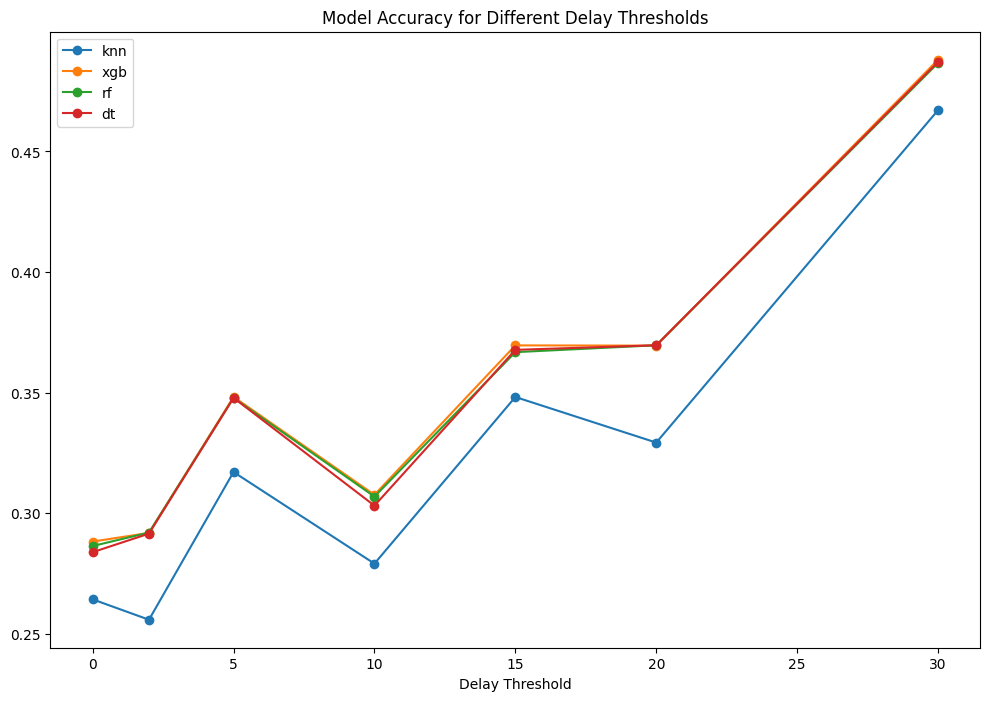

In [64]:
# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))

for model in ['knn', 'xgb', 'rf', 'dt']:
    accuracies = [best_params[(model, i)][0] for i in delay_thresholds]
    ax.plot(delay_thresholds, accuracies, marker='o', label=model)

ax.set_title('Model Accuracy for Different Delay Thresholds')
ax.set_xlabel('Delay Threshold')
ax.legend()

#plt.savefig('graphics/model_accuracy_delay_threshold.png')

In [71]:
pd.set_option('display.max_columns', None)
#dropping all things that are repeats or not useful
#drop quarter, OriginAirportSeqID, OriginCityName, OriginState, DestAirportSeqID, DestCityName, DestState, Cancelled, Diverted
df_nums = df_nums.drop(columns=['Quarter', 'OriginAirportSeqID', 'OriginCityName', 'OriginState', 'DestAirportSeqID', 'DestCityName', 'DestState', 'Cancelled', 'Diverted'])
#drop CRSArrTime since arrival time is just departure time + elapsed time
df_nums = df_nums.drop(columns=['CRSArrTime'])

df_nums.head()

DepDelay
0    119619
1    100529
2     68756
3     32937
4      3889
Name: count, dtype: int64


,Year,Month,DayofMonth,DayOfWeek,Reporting_Airline,Origin,Dest,CRSDepTime,DepDelay,CRSElapsedTime,Distance,is_holiday_week,OriginFlightDensity,Visibility,WindSpeed,SevereWeather,BadWeather
3,2014,1,1,3,1,0,1,810,0,294.0,1947.0,1,6.0,10.0,3.0,0,0
16,2014,1,1,3,2,0,3,1110,0,265.0,1587.0,1,13.0,10.0,3.0,0,0
23,2014,1,1,3,3,0,4,1245,0,145.0,731.0,1,15.0,10.0,5.0,0,0
38,2014,1,1,3,4,0,2,1516,1,207.0,1199.0,1,21.0,10.0,3.0,0,0
52,2014,1,1,3,1,0,6,1744,2,77.0,226.0,1,15.0,10.0,3.0,0,0


In [100]:
#split df_nums into X and y train and test
X = df_nums.drop(columns=['DepDelay'])
y = df_nums['DepDelay']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(260584, 16) (65146, 16) (260584,) (65146,)


In [101]:
#unique values in DepDelay
print(df_nums['DepDelay'].value_counts())
print(y_train.value_counts())
print(y_test.value_counts())

#oversample the data to balance the classes
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

print(y_resampled.value_counts())

#split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=32)

print(y_train.value_counts())
print(y_test.value_counts())

DepDelay
0    119619
1    100529
2     68756
3     32937
4      3889
Name: count, dtype: int64
DepDelay
0    95607
1    80499
2    55075
3    26279
4     3124
Name: count, dtype: int64
DepDelay
0    24012
1    20030
2    13681
3     6658
4      765
Name: count, dtype: int64
DepDelay
0    95607
1    95607
2    95607
3    95607
4    95607
Name: count, dtype: int64
DepDelay
3    76733
0    76563
4    76504
1    76438
2    76190
Name: count, dtype: int64
DepDelay
2    19417
1    19169
4    19103
0    19044
3    18874
Name: count, dtype: int64


In [112]:
#oversample the data to balance the classes
ros = RandomOverSampler(random_state=0)
X = df_nums.drop(columns=['DepDelay'])
y = df_nums['DepDelay']

X_resampled, y_resampled = ros.fit_resample(X, y)

#split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=32)

In [113]:
#preform hyperparameter tuning on the data with different thresholds for delay

param_grid_knn = {
    'n_neighbors': [2, 5, 10, 20, 50, 100, 250],
    'algorithm': ['ball_tree', 'kd_tree'],
    'leaf_size': [2, 4, 5, 10, 30]
}

param_grid_xgb = {
    'n_estimators': [50, 100, 200, 300, 1000, 2000],
    'max_depth': [2, 3, 5, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.5, 0.7, 0.9]
}

param_grid_rf = {
    'n_estimators': [50, 100, 200, 300, 1000, 2000],
    'max_depth': [2, 3, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

param_grid_dt = {
    'max_depth': [2, 3, 5, 10, 15, 20],
    'splitter': ['best', 'random'],
    'min_samples_split': [2, 3, 4, 5],
    'random_state': [None, 4],
    'min_samples_leaf': [1, 2, 4],
}


#dict of the best parameters for each delay threshold
best_params = {}


for model in ['knn', 'xgb', 'rf', 'dt']:

    if model == 'knn':
        knn = KNeighborsClassifier()
        grid_search = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=2, n_jobs=-1, verbose=2)
        grid_search.fit(X_train, y_train)

        y_pred_sample = grid_search.best_estimator_.predict(X_test)

        best_params[(model)] = [accuracy_score(y_test, y_pred_sample), grid_search.best_params_, grid_search.best_score_]

    elif model == 'xgb':
        xgb = XGBClassifier()
        grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=2, n_jobs=-1, verbose=2)
        grid_search.fit(X_train, y_train)

        y_pred_sample = grid_search.best_estimator_.predict(X_test)

        best_params[(model)] = [accuracy_score(y_test, y_pred_sample), grid_search.best_params_, grid_search.best_score_]

    elif model == 'rf':
        rf = RandomForestClassifier()
        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=2, n_jobs=-1, verbose=2)
        grid_search.fit(X_train, y_train)

        y_pred_sample = grid_search.best_estimator_.predict(X_test)

        best_params[(model)] = [accuracy_score(y_test, y_pred_sample), grid_search.best_params_, grid_search.best_score_]

    elif model == 'dt':
        dt = DecisionTreeClassifier()
        grid_search = GridSearchCV(estimator=dt, param_grid=param_grid_dt, cv=2, n_jobs=-1, verbose=2)
        grid_search.fit(X_train, y_train)

        y_pred_sample = grid_search.best_estimator_.predict(X_test)

        best_params[(model)] = [accuracy_score(y_test, y_pred_sample), grid_search.best_params_, grid_search.best_score_]

for key in best_params:
    print(f"Model: {key[0]}, Delay Threshold: {key[1]}")
    print("Accuracy: ", best_params[key][0])
    print("Best Params: ", best_params[key][1])
    print("Best Train Score: ", best_params[key][2])
    print("\n")

#save the dict to a file

# Prepare data for serialization
def prepare_for_json(best_params):
    prepared_dict = {}
    for key, values in best_params.items():
        accuracy, params, best_score = values
        # Ensure all parameter values are JSON serializable
        params = {k: (v.tolist() if isinstance(v, np.ndarray) else v) for k, v in params.items()}
        prepared_dict[str(key)] = [accuracy, params, best_score]
    return prepared_dict

# Convert complex objects to a serializable form
best_params_serializable = prepare_for_json(best_params)

# Serialize to JSON and write to a file
try:
    with open('best_params_final_2.json', 'w') as f:
        json.dump(best_params_serializable, f, indent=4)  # Writing with indentation for better readability
    print("Data successfully written to 'best_params_final'.")
except Exception as e:
    print(f"An error occurred while writing to the file: {e}")



Fitting 2 folds for each of 70 candidates, totalling 140 fits
[CV] END ....algorithm=ball_tree, leaf_size=2, n_neighbors=2; total time=  36.5s
[CV] END ....algorithm=ball_tree, leaf_size=2, n_neighbors=2; total time=  37.1s
[CV] END ....algorithm=ball_tree, leaf_size=2, n_neighbors=5; total time=  42.9s
[CV] END ....algorithm=ball_tree, leaf_size=2, n_neighbors=5; total time=  43.6s
[CV] END ...algorithm=ball_tree, leaf_size=2, n_neighbors=10; total time=  49.3s
[CV] END ...algorithm=ball_tree, leaf_size=2, n_neighbors=10; total time=  53.7s
[CV] END ...algorithm=ball_tree, leaf_size=2, n_neighbors=20; total time= 1.0min
[CV] END ...algorithm=ball_tree, leaf_size=2, n_neighbors=20; total time= 1.1min
[CV] END ....algorithm=ball_tree, leaf_size=4, n_neighbors=2; total time=  37.1s
[CV] END ....algorithm=ball_tree, leaf_size=4, n_neighbors=2; total time=  36.5s
[CV] END ...algorithm=ball_tree, leaf_size=2, n_neighbors=50; total time= 1.5min
[CV] END ...algorithm=ball_tree, leaf_size=2, n

/opt/homebrew/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ...algorithm=ball_tree, leaf_size=5, n_neighbors=10; total time= 1.0min
[CV] END ...algorithm=ball_tree, leaf_size=5, n_neighbors=10; total time= 1.0min
[CV] END ...algorithm=ball_tree, leaf_size=5, n_neighbors=20; total time= 1.2min
[CV] END ...algorithm=ball_tree, leaf_size=5, n_neighbors=20; total time= 1.3min
[CV] END ...algorithm=ball_tree, leaf_size=5, n_neighbors=50; total time= 1.7min
[CV] END ...algorithm=ball_tree, leaf_size=5, n_neighbors=50; total time= 1.7min
[CV] END ..algorithm=ball_tree, leaf_size=4, n_neighbors=250; total time= 3.6min
[CV] END ..algorithm=ball_tree, leaf_size=4, n_neighbors=250; total time= 3.6min
[CV] END ...algorithm=ball_tree, leaf_size=10, n_neighbors=2; total time=  45.9s
[CV] END ...algorithm=ball_tree, leaf_size=10, n_neighbors=2; total time=  46.9s
[CV] END ...algorithm=ball_tree, leaf_size=10, n_neighbors=5; total time=  51.9s
[CV] END ...algorithm=ball_tree, leaf_size=10, n_neighbors=5; total time=  54.9s
[CV] END ..algorithm=ball_tr

/opt/homebrew/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END learning_rate=0.01, max_depth=2, n_estimators=200, subsample=0.5; total time=  24.0s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=200, subsample=0.5; total time=  24.6s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=200, subsample=0.7; total time=  22.6s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=200, subsample=0.7; total time=  23.0s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=200, subsample=0.9; total time=  22.0s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=200, subsample=0.9; total time=  21.9s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=300, subsample=0.5; total time=  36.6s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=300, subsample=0.5; total time=  36.2s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=300, subsample=0.7; total time=  35.0s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=300, subsample=0.7; total time=  36.1s
[CV] END learning_rate=0.01, max_depth=2, n_estimators=300, 

/opt/homebrew/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time= 2.6min
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time= 2.6min
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=24.1min
[CV] END criterion=gini, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=2000; total time=24.1min
[CV] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   8.3s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   7.9s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  16.2s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=  16.2s
[CV] END criterion=gini, max_depth=5, min_samples_leaf=2, min_samples_

0.7369648634414265


<Axes: >

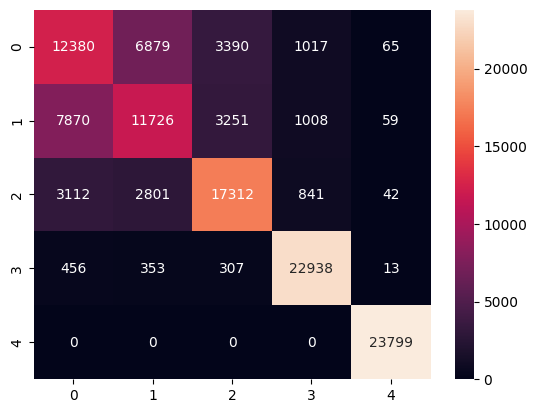

In [115]:
#xgboost model, found through hyperparameter tuning
"""
"learning_rate": 0.01,
"max_depth": 15,
"n_estimators": 2000,
"subsample": 0.9
"""
xgb = XGBClassifier(learning_rate=0.01, max_depth=15, n_estimators=2000, subsample=0.9)
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

print(accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

0.7369648634414265


<Axes: >

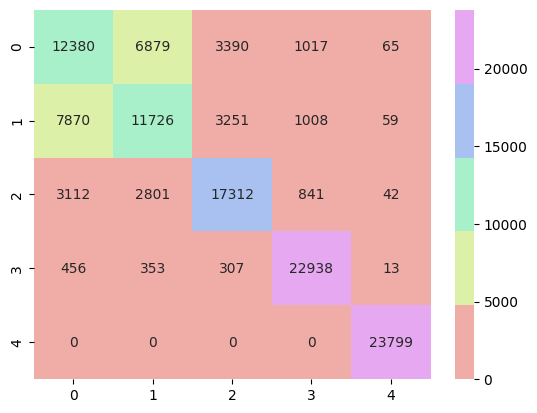

In [117]:
#make this cm
y_pred = xgb.predict(X_test)

print(accuracy_score(y_test, y_pred))

#cm = confusion_matrix(y_test, y_pred)
#sns.heatmap(cm, annot=True, fmt='d')

#with this palette
#palette=sns.hls_palette(5, l=.8, s=.7))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap=sns.cubehelix_palette(100, start=0.5, rot=1.5, dark=0.3, light=0.8, reverse=False, hue=1))
plt.xlabel('Predicted')
plt.ylabel('True')
#plt.savefig('graphics/xgbooost_confusion_matrix.png')

0.5614325483409827


<Axes: >

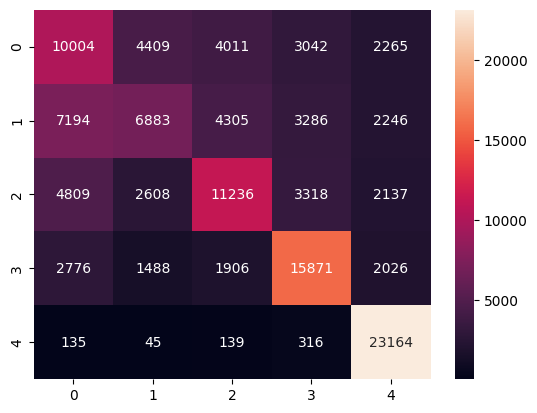

In [161]:
#random forest model
"""
"criterion": "entropy",
"max_depth": 15,
"min_samples_leaf": 1,
"min_samples_split": 2,
"n_estimators": 2000
"""
rf = RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_leaf=1, min_samples_split=2, n_estimators=2000)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

0.5284862772636454


<Axes: >

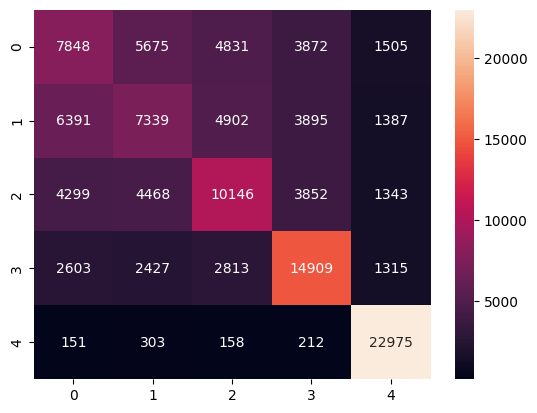

In [162]:
#decision tree model
"""
"max_depth": 20,
"min_samples_leaf": 1,
"min_samples_split": 2,
"random_state": null,
"splitter": "best"
"""
dt = DecisionTreeClassifier(max_depth=20, min_samples_leaf=1, min_samples_split=2, random_state=None, splitter='best')
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)

print(accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

0.6256781949355872


<Axes: >

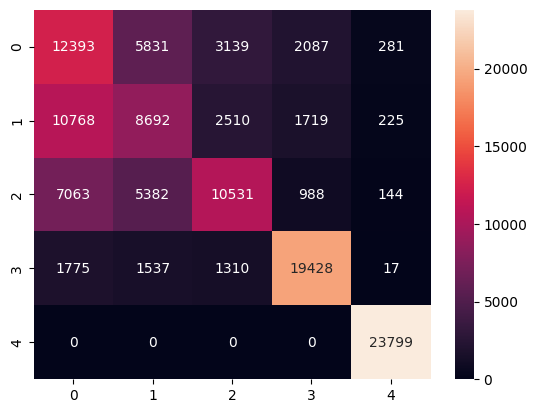

In [163]:
#knn model
"""
"algorithm": "ball_tree",
"leaf_size": 30,
"n_neighbors": 2
"""
knn = KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, n_neighbors=2)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

0.6328509684916276


<Axes: >

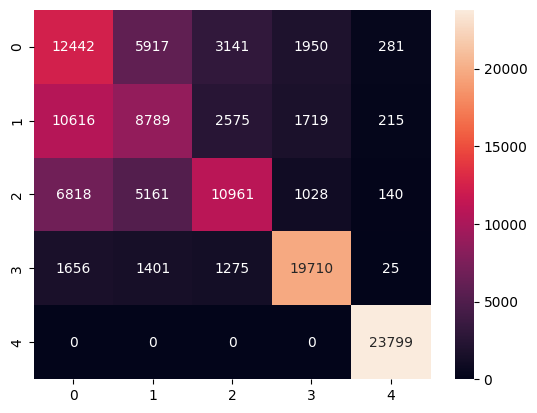

In [166]:
#rerun knn with scaled data
#only scaling the biggest values
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[['Distance', 'CRSElapsedTime', 'TotalDensity', 'CRSDepTime', 'Year']] = scaler.fit_transform(X_train[['Distance', 'CRSElapsedTime', 'TotalDensity', 'CRSDepTime', 'Year']])
X_test_scaled = X_test.copy()
X_test_scaled[['Distance', 'CRSElapsedTime', 'TotalDensity', 'CRSDepTime', 'Year']] = scaler.transform(X_test[['Distance', 'CRSElapsedTime', 'TotalDensity', 'CRSDepTime', 'Year']])
knn = KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, n_neighbors=2)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

print(accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')

In [164]:
#print feature importance for xgboost by percentage
#xgboost is the best since it predicts across all delay thresholds and has the same accuracy as the other models
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]

total = importances.sum()
importances = (importances/total)*100

print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f+1}. feature {X_train.columns[indices[f]]} ({round(importances[indices[f]], 2)}%)")

#add up the feature importance percentages for weather features
weather_features = ['SevereWeather', 'BadWeather', 'Visibility', 'WindSpeed']
weather_importance = 0
for f in range(X_train.shape[1]):
    if X_train.columns[indices[f]] in weather_features:
        weather_importance += importances[indices[f]]

print("Weather Importance: ", round(weather_importance, 2))

Feature ranking:
1. feature SevereWeather (19.389999389648438%)
2. feature Origin (6.429999828338623%)
3. feature BadWeather (6.230000019073486%)
4. feature Reporting_Airline (6.019999980926514%)
5. feature Distance (5.860000133514404%)
6. feature CRSDepTime (5.460000038146973%)
7. feature TotalDensity (5.369999885559082%)
8. feature CRSElapsedTime (5.139999866485596%)
9. feature is_holiday_week (5.099999904632568%)
10. feature Dest (5.099999904632568%)
11. feature DayofMonth (5.079999923706055%)
12. feature Year (5.059999942779541%)
13. feature Visibility (5.03000020980835%)
14. feature Month (5.019999980926514%)
15. feature WindSpeed (4.849999904632568%)
16. feature DayOfWeek (4.829999923706055%)
Weather Importance:  35.52
